# MMED Week 2 Project: COVID-19

# The Impact of Timing Threshold of Non-Pharmaceutical Interventions (NPIs) on ICU Beds Occupancy for Covid-19 Outbreak in Italy.

Group 1<br>
Project: COVID-19 Decision Making<br><br>

**Supervisor:**<br>
 - Dr. Jeanette Dawa
 
**Mentor:**<br>
 - Emmanuel Ahenkan

**Students:**<br>
 - Annette Dariose Diffo Mboudjiho
 - Dishanand Jayeprokash
 - German Shâma Wache
 - Oumarou MOUSSA BOLA
 - Tiwonge Chirwa
 - Yvan Marcel Carre

## Data Preparation

In [1]:
# Install and load necessary packages
install.packages(c("deSolve", "ggplot2", "minpack.lm", "coda", "patchwork"))
install.packages("GillespieSSA")


Installing packages into ‘/var/autofs/misc/home/jay/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)

Warning message in install.packages(c("deSolve", "ggplot2", "minpack.lm", "coda", :
“installation of package ‘deSolve’ had non-zero exit status”
Warning message in install.packages(c("deSolve", "ggplot2", "minpack.lm", "coda", :
“installation of package ‘minpack.lm’ had non-zero exit status”
Installing package into ‘/var/autofs/misc/home/jay/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



In [2]:
library(deSolve)
library(ggplot2)
library(minpack.lm)
library(coda)
library(dplyr)
library(patchwork)
library(GillespieSSA)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Load the data
covid_bed<- read.csv("hospitalization.csv")
covid_bed <- covid_bed[1:150,]
head(covid_bed)

,Time,excluded_ICU_cases,ICU_cases,total_cases
,<chr>,<int>,<int>,<int>
1,2020-02-24,101,26,127
2,2020-02-25,114,35,149
3,2020-02-26,128,36,164
4,2020-02-27,248,56,304
5,2020-02-28,345,64,409
6,2020-02-29,401,105,506


In [4]:
dim(covid_bed)

[1] 150   4

In [5]:
# Preprocess the data - Convert Date column to Date type
covid_bed$Date <- as.Date(covid_bed$Time)
# Extract the count of hospitaloized cases
non_icu <- covid_bed$excluded_ICU_cases
icu <- covid_bed$ICU_cases
total_case <- covid_bed$total_cases
dates <- covid_bed$Date
times <- 1:length(total_case) # Time in days

## Visualization

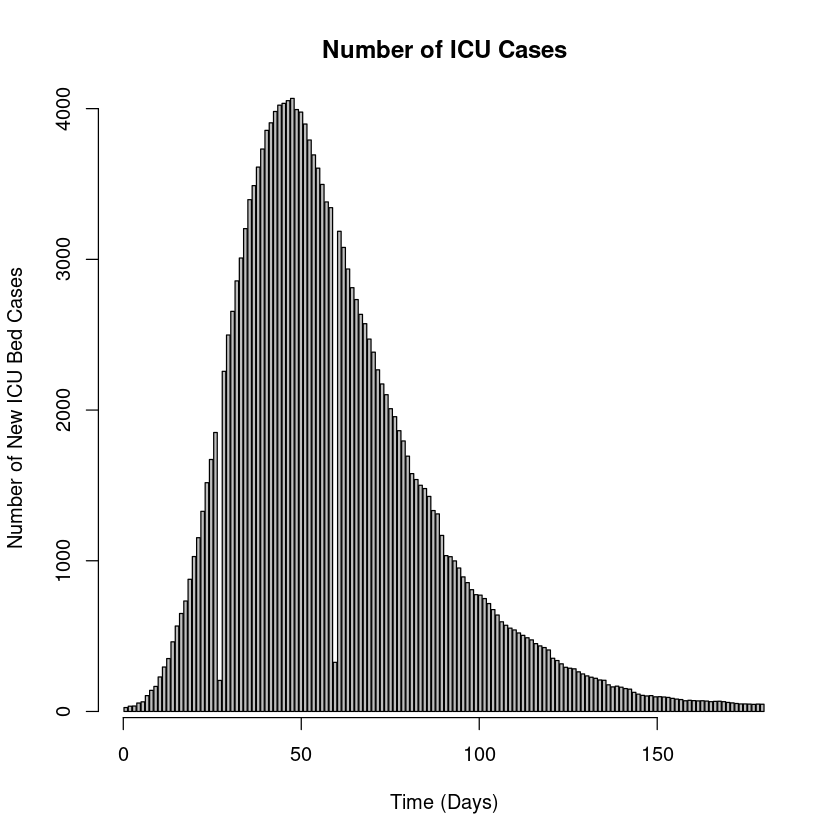

In [6]:
# Plot the real data
barplot(covid_bed$ICU_cases, xlab = "Time (Days)", ylab = "Number of New ICU Bed Cases",
        main = "Number of ICU Cases")
axis(side = 1, at = seq(0,nrow(covid_bed), 50))
# covid_bed$ICU_cases[1:500,3]
# covid_bed$ICU_cases

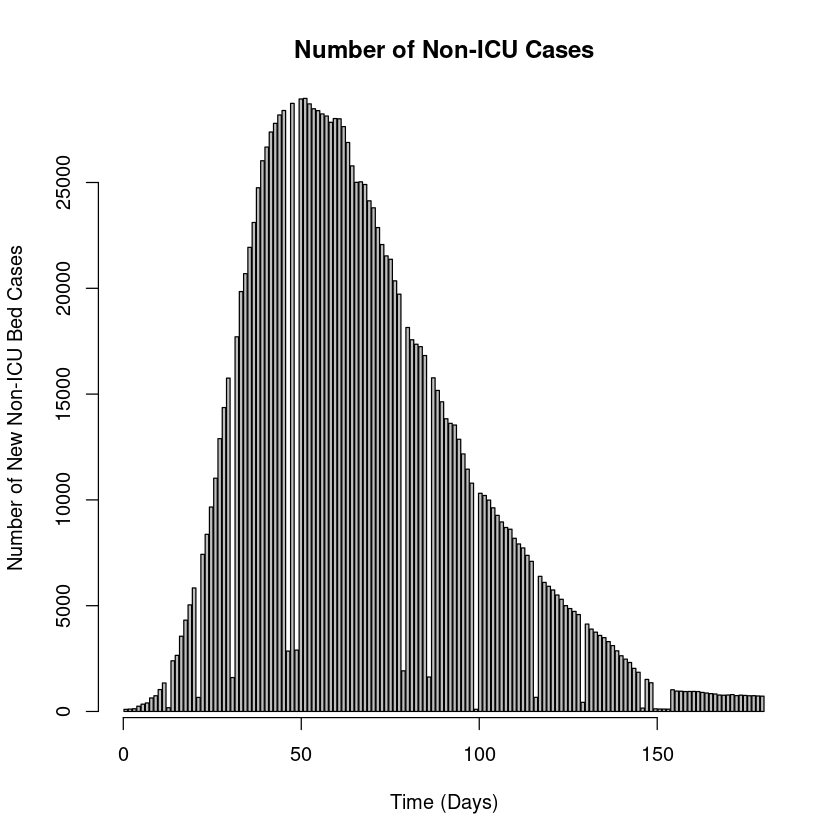

In [7]:
# Plot the real data
barplot(covid_bed$excluded_ICU_cases, xlab = "Time (Days)", ylab = "Number of New Non-ICU Bed Cases",
        main = "Number of Non-ICU Cases")
axis(side = 1, at = seq(0,nrow(covid_bed), 50))

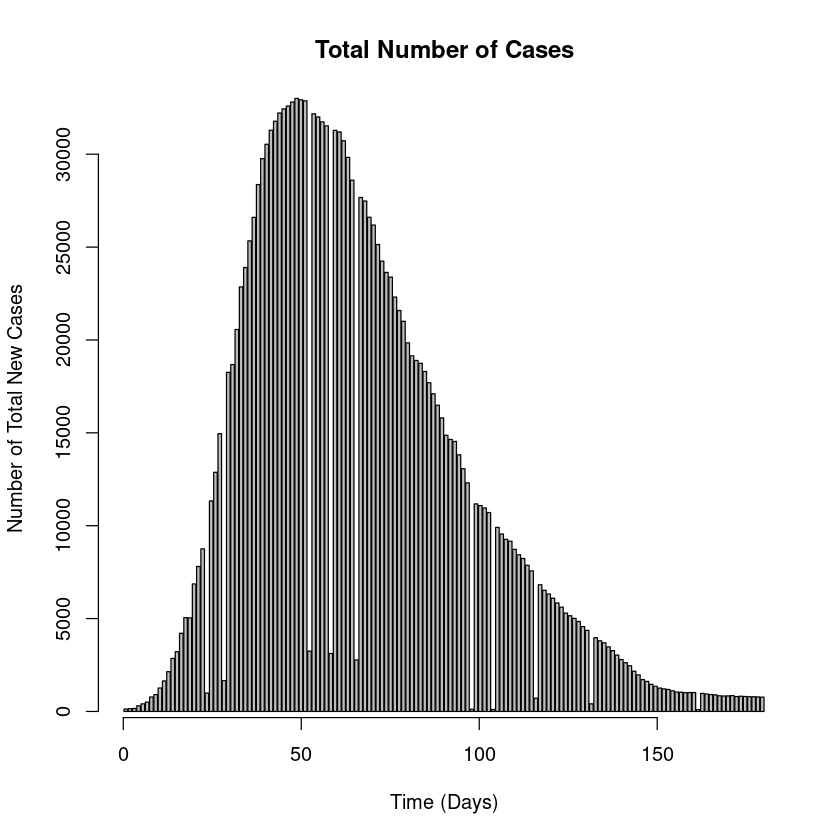

In [8]:
# Plot the real data
barplot(covid_bed$total_cases, xlab = "Time (Days)", ylab = "Number of Total New Cases",
        main = "Total Number of Cases")
axis(side = 1, at = seq(0,nrow(covid_bed), 50))

In [9]:
max(total_case)

[1] 33004

## Cummulative Cases of the Covid-19 Pandemic in Italy

In [10]:
# Convert 'Date' to the proper format and ensure it's sorted
covid_bed$Date <- as.Date(covid_bed$Date, format = "%Y-%m-%d")
covid_bed <- arrange(covid_bed, Date)

# Calculate the cumulative cases
covid_bed <- mutate(covid_bed, CumulativeCases = cumsum(total_cases))

# Calculate days since the start of the dataset
covid_bed <- mutate(covid_bed, DaysSinceStart = as.numeric(Date - min(Date)))

# Find the values for annotations
Feb_24_date <- as.numeric(as.Date("2020-02-24") - min(covid_bed$Date))
Feb_24_cases <- covid_bed$CumulativeCases[which(covid_bed$DaysSinceStart == Feb_24_date)]

Jul_23_date <- as.numeric(as.Date("2020-07-23") - min(covid_bed$Date))
Jul_23_cases <- covid_bed$CumulativeCases[which(covid_bed$DaysSinceStart == Jul_23_date)]


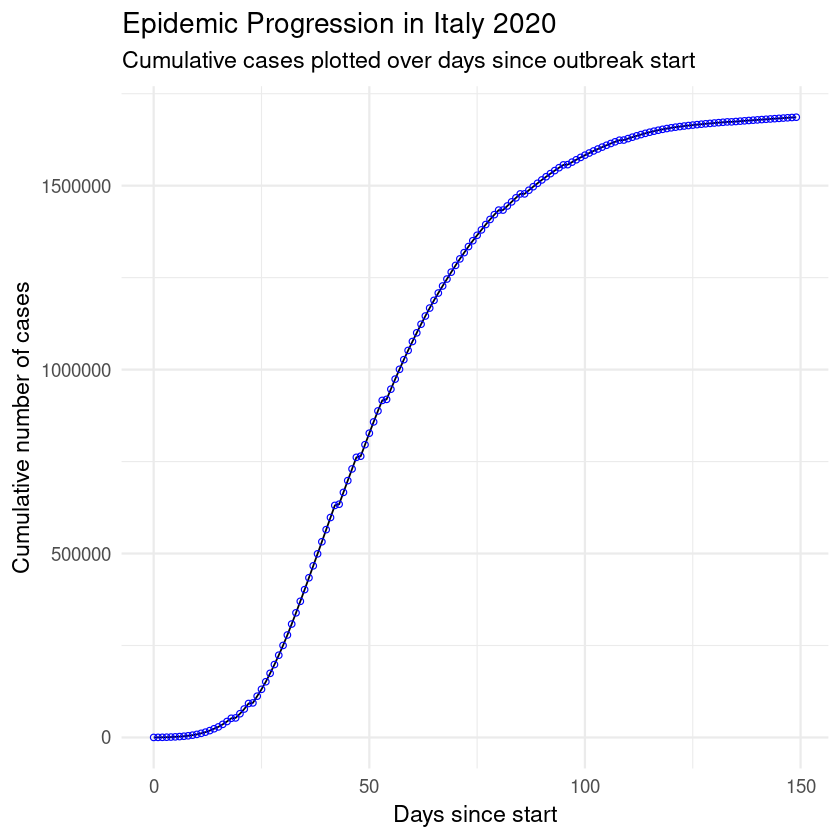

In [11]:
ggplot(covid_bed, aes(x = DaysSinceStart, y = CumulativeCases)) +
   geom_line() +  # Add the line for cumulative cases
  geom_point(color="blue",shape = 1) +  # Add points for each day
  scale_x_continuous(breaks = c(0, 50, 100, 150), labels = c("0", "50", "100", "150")) +
  annotate("text", x = Feb_24_date, y = Feb_24_cases, label = "Feb 24", color = "white", hjust = 1.5, vjust = -0.5, fontface = "bold", size = 5) +
  annotate("text", x = Jul_23_date, y = Jul_23_cases, label = "Jul 23", color = "white", hjust = -0.5, vjust = -0.5, fontface = "bold", size = 5) +
  labs(title = "Epidemic Progression in Italy 2020", subtitle = "Cumulative cases plotted over days since outbreak start", x = "Days since start", y = "Cumulative number of cases") +
  theme_minimal(base_size = 14) +
  theme(plot.background = element_rect(fill = "white", colour = "white"), 
        panel.background = element_rect(fill = "white", colour = "white"))  # Set background to white


In [12]:
getwd()

[1] "/var/autofs/misc/home/jay/Desktop/group_1_mmed/COVID-19-Making-Decision"

## $\beta$ as a Function of t

In [13]:
# Define the function to calculate beta(t)
#Transmission rate that model the delay of the intervention
beta_t <- function(t, tau, beta_0, beta_1, q) {
  if (t < tau) {
    return(beta_0)
  } else {
    return(beta_1 + (beta_0 - beta_1) * exp(-q * (t - tau)))
  }
}


## SEIR Model Implementation

In [15]:
# SEIR model differential equations : Taking new assumptions into account\

seir <- function(t, y, params) {
  S <- y[1]
  E <- y[2]
  I <- y[3]
  R <- y[4]
  B_n <- y[5]
  B_icu <- y[6]
  D <- y[7]
  
  beta <- beta_t(t, params["tau"], params["beta_0"], params["beta_1"], params["q"])
  N <- params["N"]
  gamma <- params["gamma"]
  alpha <- params["alpha"]
  lambda1 <- params["lambda1"]
  lambda2 <- params["lambda2"]
  sigma <- params["sigma"]
  delta <- params["delta"]
  theta <- params["theta"]
  
  dSdt <- -(beta * S * I) / N
  dEdt <- (beta * S * I) / N - sigma * E
  dIdt <- sigma * E - (gamma + alpha) * I
  dRdt <- gamma * I + theta * B_n
  dB_ndt <- alpha * I + lambda2 * B_icu - (theta + lambda1) * B_n
  dB_icudt <- lambda1 * B_n - (lambda2 + delta) * B_icu
  dDdt <- delta * B_icu
  
  return(list(c(dSdt, dEdt, dIdt, dRdt, dB_ndt, dB_icudt, dDdt)))

## Initial Conditions

In [22]:
# Parameters and initial conditions
latent_period=5.6 #[days]
params <- c(
  beta_0 = 2.8,
  beta_1 = 2,
  gamma = 1/12,
  alpha = 0.75  ,
  lambda1 =10,
  lambda2 =60.5  ,
  theta = 1/15,
  delta = 1/8,
  tau = 50,
  q = 25,
  N = 120000 ,
  sigma=1/latent_period  )  
    
initial_conditions <- c(S = 120000 - 70100, E = 50000, I = 10000, R = 100, B_n=10000, B_icu = 100, D = 0)
times <- seq(1, 150, by = 1)

## Simulate SEIR Model

In [23]:
# Solve the SEIR model
seir_output <- ode(y = initial_conditions, times = times, func = seir, parms = params)


In [24]:
# Convert the output to a data frame
seir_df <- as.data.frame(seir_output)

In [25]:
head(seir_df)

,time,S,E,I,R,B_n,B_icu,D
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,49900.00,50000.00,10000.000,100.000,10000.00,100.000,0.0000
2,2,39257.22,51542.72,10532.733,1729.193,14437.91,2365.994,234.2331
3,3,30586.81,51027.60,10805.157,3770.857,20032.07,3289.398,588.1087
4,4,23771.87,48900.02,10745.320,6184.137,25287.02,4157.364,1054.2709
5,5,18569.38,45647.64,10379.157,8913.297,30025.97,4940.648,1623.9105
6,6,14672.64,41735.61,9776.236,11896.425,34116.79,5617.312,2284.9769


In [26]:
dim(seir_df)

[1] 150   8

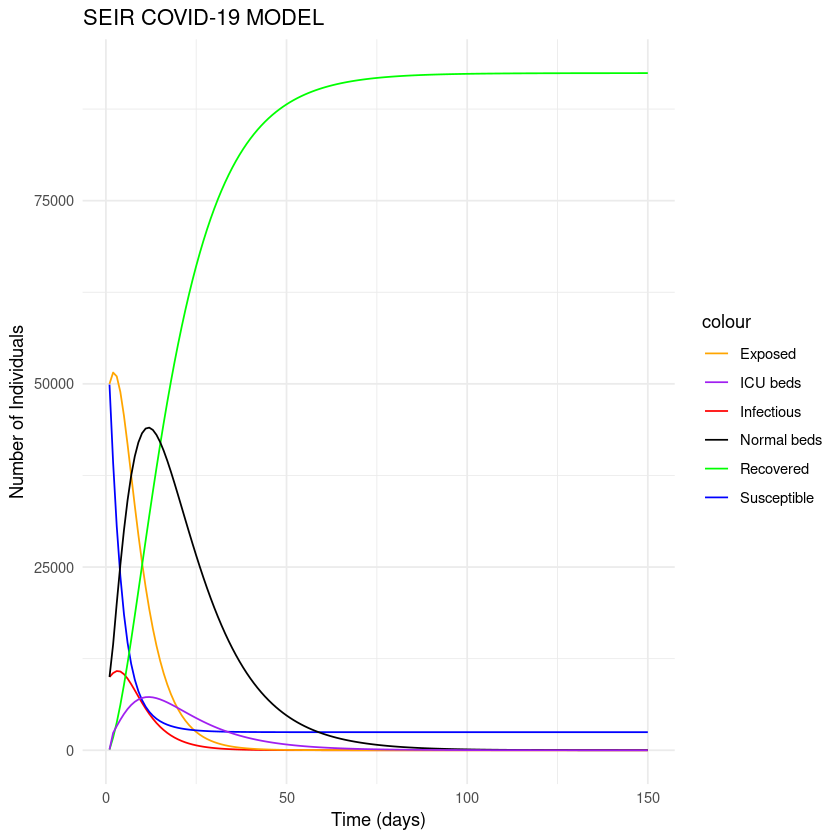

In [27]:
# Plot the simulation results
ggplot(seir_df, aes(x = time)) +
  geom_line(aes(y = I, color = "Infectious")) +
  geom_line(aes(y = E, color = "Exposed")) +
  geom_line(aes(y = S, color = "Susceptible")) +
  geom_line(aes(y = R, color = "Recovered")) +
  geom_line(aes(y = B_n, color = "Normal beds")) +
  geom_line(aes(y = B_icu, color = "ICU beds")) +
  labs(title = "SEIR COVID-19 MODEL",
       x = "Time (days)", y = "Number of Individuals") +
  scale_color_manual(values = c("Infectious" = "red", "Exposed" = "orange", "Susceptible" = "blue", "Recovered" ="green","Normal beds" = "black","ICU beds" = "purple")) +
  theme_minimal()

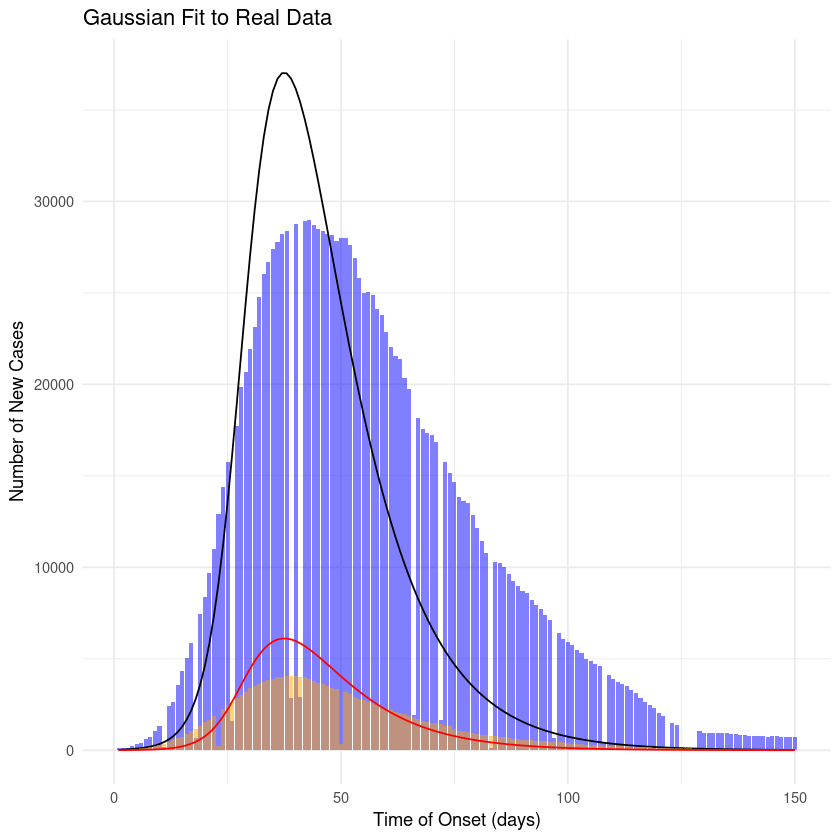

In [21]:
# Plot the real data and Gaussian fit
ggplot() +
  geom_bar(data = covid_bed, aes(x = times, y = non_icu), stat = "identity", fill = "blue", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_n), color = "black") +
  geom_bar(data = covid_bed, aes(x = times, y = icu), stat = "identity", fill = "orange", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_icu), color = "red") +
  labs(title = "Gaussian Fit to Real Data",
       x = "Time of Onset (days)", y = "Number of New Cases") +
  theme_minimal()

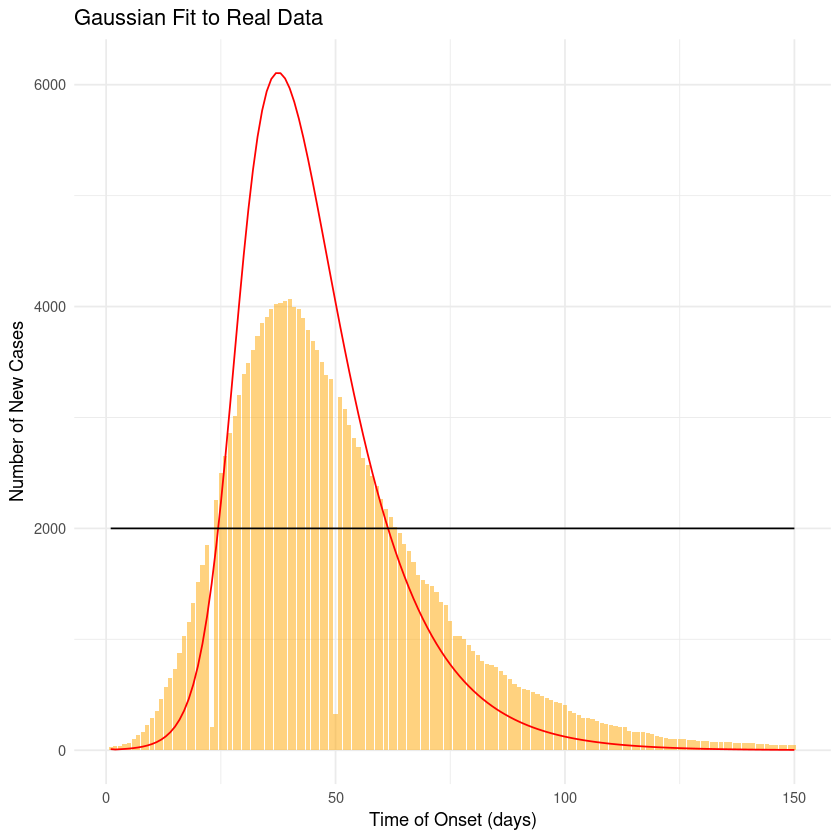

In [22]:
# Plot the real data and Gaussian fit
ggplot() +
  geom_bar(data = covid_bed, aes(x = times, y = icu), stat = "identity", fill = "orange", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_icu), color = "red") +
  geom_line(aes(x = times, y = 2000), color = "black") +
  labs(title = "Gaussian Fit to Real Data",
       x = "Time of Onset (days)", y = "Number of New Cases") +
  theme_minimal()

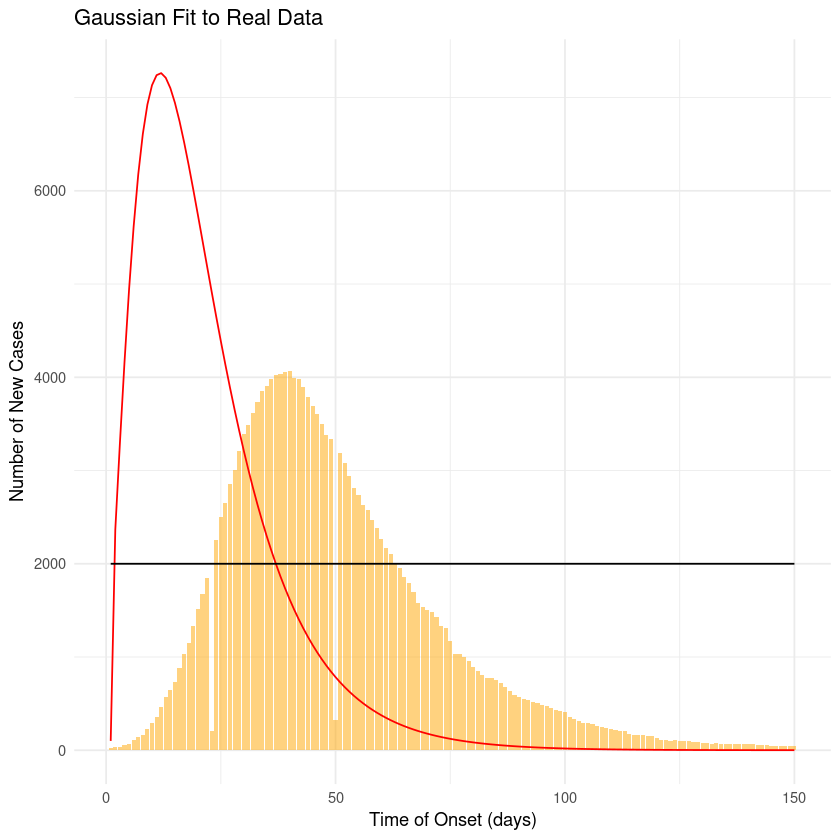

In [45]:
# Plot the real data and Gaussian fit
ggplot() +
  geom_bar(data = covid_bed, aes(x = times, y = icu), stat = "identity", fill = "orange", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_icu), color = "red") +
  geom_line(aes(x = times, y = 2000), color = "black") +
  labs(title = "Gaussian Fit to Real Data",
       x = "Time of Onset (days)", y = "Number of New Cases") +
  theme_minimal()

## ICU Occupancy with Different Time to Intervention (tau)

## SEIR Model

In [28]:
# SEIR Model
seir <- function(t, y, params) {
  S <- y[1]
  E <- y[2]
  I <- y[3]
  R <- y[4]
  B_n <- y[5]
  B_icu <- y[6]
  D <- y[7]
  
  beta <- beta_t(t, params["tau"], params["beta_0"], params["beta_1"], params["q"])
  N <- params["N"]
  gamma <- params["gamma"]
  alpha <- params["alpha"]
  lambda1 <- params["lambda1"]
  lambda2 <- params["lambda2"]
  sigma <- params["sigma"]
  delta <- params["delta"]
  theta <- params["theta"]
  
  dSdt <- -(beta * S * I) / N
  dEdt <- (beta * S * I) / N - sigma * E
  dIdt <- sigma * E - (gamma + alpha) * I
  dRdt <- gamma * I + theta * B_n
  dB_ndt <- alpha * I + lambda2 * B_icu - (theta + lambda1) * B_n
  dB_icudt <- lambda1 * B_n - (lambda2 + delta) * B_icu
  dDdt <- delta * B_icu
  
  return(list(c(dSdt, dEdt, dIdt, dRdt, dB_ndt, dB_icudt, dDdt)))
}

# Transmission rate function
beta_t <- function(t, tau, beta_0, beta_1, q) {
  if (t < tau) {
    return(beta_0)
  } else {
    return(beta_1 + (beta_0 - beta_1) * exp(-q * (t - tau)))
  }
}

## Initial Conditions

In [29]:
# Parameters and initial conditions
latent_period <- 5.6 # [days]
params <- c(
  beta_0 = 2.8,
  beta_1 = 2,
  gamma = 1/12,
  alpha = 0.75,
  lambda1 = 10,
  lambda2 = 60.5,
  theta = 1/15,
  delta = 1/8,
  q = 100,
  N = 120000,
  sigma = 1/latent_period
)

initial_conditions <- c(S = 119920, E = 10, I = 50, R = 0, B_n = 10, B_icu = 10, D = 0)
times <- seq(1, 150, by = 1)
taus <- c(0, 10, 20, 30, 50)
icu_capacity <- 5000


## Running the Simulation

In [30]:
# Run the simulations for each value of tau
results <- list()
max_icu_cases <- numeric(length(taus))

for (i in seq_along(taus)) {
  params["tau"] <- taus[i]
  seir_output <- ode(y = initial_conditions, times = times, func = seir, parms = params)
  results[[as.character(taus[i])]] <- seir_output
  max_icu_cases[i] <- max(seir_output[, "B_icu"])
}

# Select the best tau
best_tau_index <- which.max(max_icu_cases[max_icu_cases <= icu_capacity])
best_tau <- taus[best_tau_index]

# Create combined_df in the global environment
df_list <- lapply(names(results), function(tau) {
  df <- as.data.frame(results[[tau]])
  df$tau <- tau
  return(df)
})
combined_df <- do.call(rbind, df_list)

## Visualization

In [31]:
# Plotting function
plot_results <- function(results, variable, title, icu_capacity, best_tau, max_icu_cases, best_tau_index) {
  df_list <- lapply(names(results), function(tau) {
    df <- as.data.frame(results[[tau]])
    df$tau <- tau
    return(df)
  })
  combined_df <- do.call(rbind, df_list)
  
  ggplot(combined_df, aes(x = time, y = get(variable), color = as.factor(tau))) +
    geom_line() +
    geom_hline(yintercept = icu_capacity, linetype = "dashed", color = "red") +
    geom_vline(xintercept = best_tau, linetype = "solid", color = "black") +
#     geom_hline(yintercept = max_icu_cases[best_tau_index], linetype = "dashed", color = "black") +
    annotate("text", x = max(times) - 30, y = icu_capacity + 200, label = "ICU Beds Capacity Limit", color = "red") +
#     annotate("text", x = best_tau + 90, y = max_icu_cases[best_tau_index] - 200, label = "Max ICU Cases at Intervention", color = "black") +
    annotate("text", x = best_tau + 15, y = 0, label = paste("Best Tau =", best_tau), color = "black") +
    labs(x = "Time (days)", y = "ICU Beds Occpupied by Disease-Induced Patients", color = "Time to Intervene (tau)") +
    theme_minimal()
}

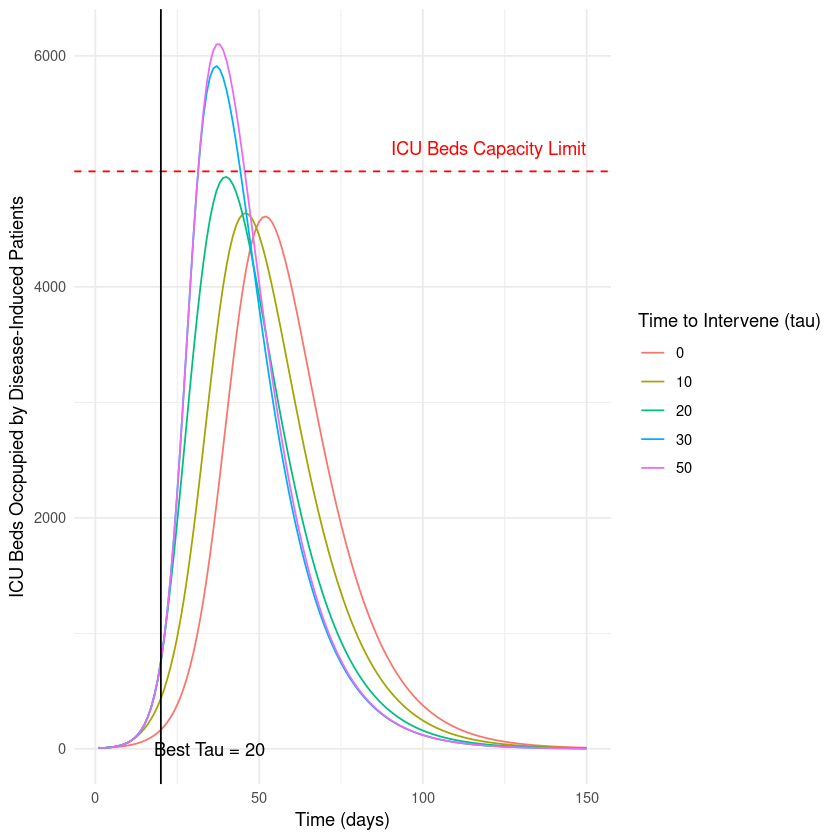

In [32]:
# Generate the plot
plot <- plot_results(results, "B_icu", "ICU Cases over Time for Different Tau Values", icu_capacity, best_tau, max_icu_cases, best_tau_index)

# # Save the plot as a PDF
# ggsave("ICU_Cases_Tau.pdf", plot = plot, width = 10, height = 6)

# View the plot
print(plot)

## Zoom-In Visualization

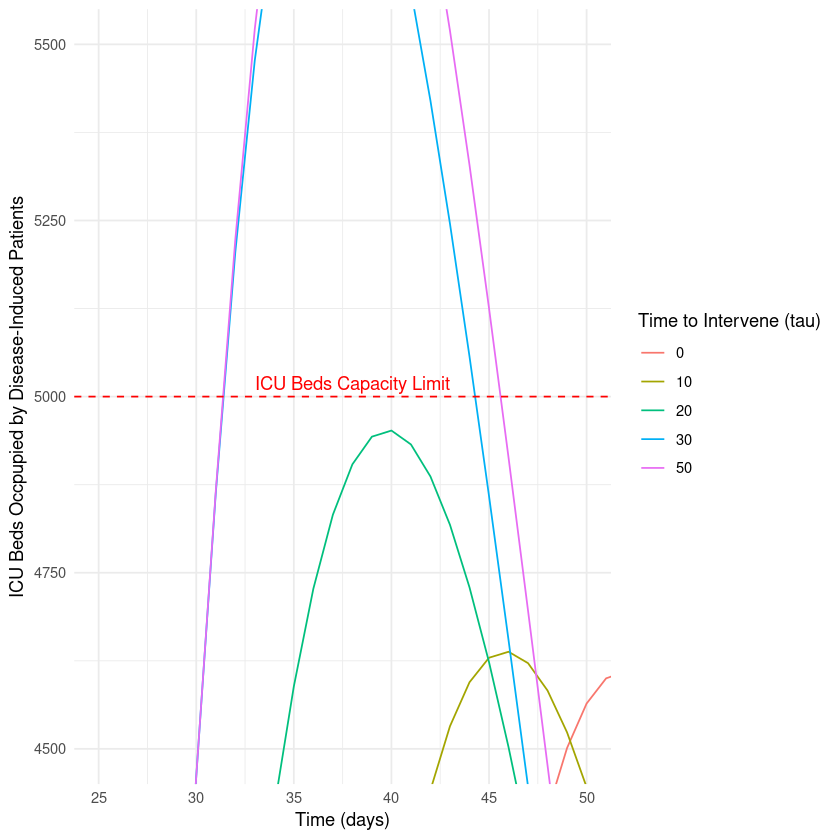

In [33]:
# Create zoomed-in plot
zoomed_plot <- ggplot(combined_df, aes(x = time, y = B_icu, color = as.factor(tau), group = tau)) +
  geom_line() +
  geom_hline(yintercept = icu_capacity, linetype = "dashed", color = "red") +
  coord_cartesian(xlim = c(25, 50), ylim = c(4500, 5500)) +
  labs(x = "Time (days)", y = "ICU Beds Occpupied by Disease-Induced Patients", color = "Time to Intervene (tau)") +
  annotate("text", x = 33, y = icu_capacity + 20, label = "ICU Beds Capacity Limit", color = "red", hjust = 0) +
  theme_minimal()

# Save the zoomed-in plot as a PDF
# ggsave("ICU_Cases_Tau_Zoom.pdf", plot = zoomed_plot, width = 10, height = 6)

# View the zoomed-in plot
print(zoomed_plot)


## Narrowing Down the Value of tau (Time to Intervention)

In [34]:
# Parameters and initial conditions
latent_period <- 5.6 # [days]
params <- c(
  beta_0 = 2.8,
  beta_1 = 2,
  gamma = 1/12,
  alpha = 0.75,
  lambda1 = 10,
  lambda2 = 60.5,
  theta = 1/15,
  delta = 1/8,
  q = 100,
  N = 120000,
  sigma = 1/latent_period
)

initial_conditions <- c(S = 119920, E = 10, I = 50, R = 0, B_n = 10, B_icu = 10, D = 0)
times <- seq(1, 150, by = 1)
taus <- c(18, 19, 20, 21, 22)
icu_capacity <- 5000

In [35]:
# Run the simulations for each value of tau
results <- list()
max_icu_cases <- numeric(length(taus))

for (i in seq_along(taus)) {
  params["tau"] <- taus[i]
  seir_output <- ode(y = initial_conditions, times = times, func = seir, parms = params)
  results[[as.character(taus[i])]] <- seir_output
  max_icu_cases[i] <- max(seir_output[, "B_icu"])
}

# Select the best tau
best_tau_index <- which.max(max_icu_cases[max_icu_cases <= icu_capacity])
best_tau <- taus[best_tau_index]

# Create combined_df in the global environment
df_list <- lapply(names(results), function(tau) {
  df <- as.data.frame(results[[tau]])
  df$tau <- tau
  return(df)
})
combined_df <- do.call(rbind, df_list)

In [36]:
# Plotting function
plot_results <- function(results, variable, title, icu_capacity, best_tau, max_icu_cases, best_tau_index) {
  df_list <- lapply(names(results), function(tau) {
    df <- as.data.frame(results[[tau]])
    df$tau <- tau
    return(df)
  })
  combined_df <- do.call(rbind, df_list)
  
  ggplot(combined_df, aes(x = time, y = get(variable), color = as.factor(tau))) +
    geom_line() +
    geom_hline(yintercept = icu_capacity, linetype = "dashed", color = "red") +
    geom_vline(xintercept = best_tau, linetype = "solid", color = "black") +
#     geom_hline(yintercept = max_icu_cases[best_tau_index], linetype = "dashed", color = "black") +
    annotate("text", x = max(times) - 30, y = icu_capacity + 200, label = "ICU Beds Capacity Limit", color = "red") +
#     annotate("text", x = best_tau + 90, y = max_icu_cases[best_tau_index] - 200, label = "Max ICU Cases at Intervention", color = "black") +
    annotate("text", x = best_tau + 15, y = 0, label = paste("Best Tau =", best_tau), color = "black") +
    labs(x = "Time (days)", y = "ICU Beds Occpupied by Disease-Induced Patients", color = "Time to Intervene (tau)") +
    theme_minimal()
}

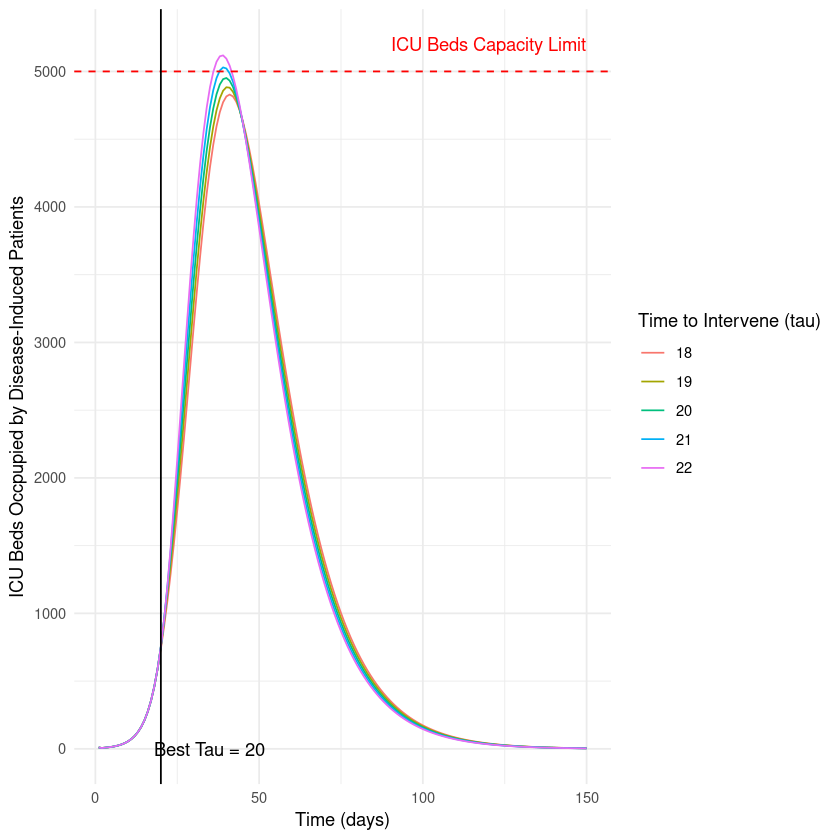

In [37]:
# Generate the plot
plot <- plot_results(results, "B_icu", "ICU Cases over Time for Different Tau Values", icu_capacity, best_tau, max_icu_cases, best_tau_index)

# # Save the plot as a PDF
# ggsave("ICU_Cases_Tau_narrow.pdf", plot = plot, width = 10, height = 6)

# View the plot
print(plot)

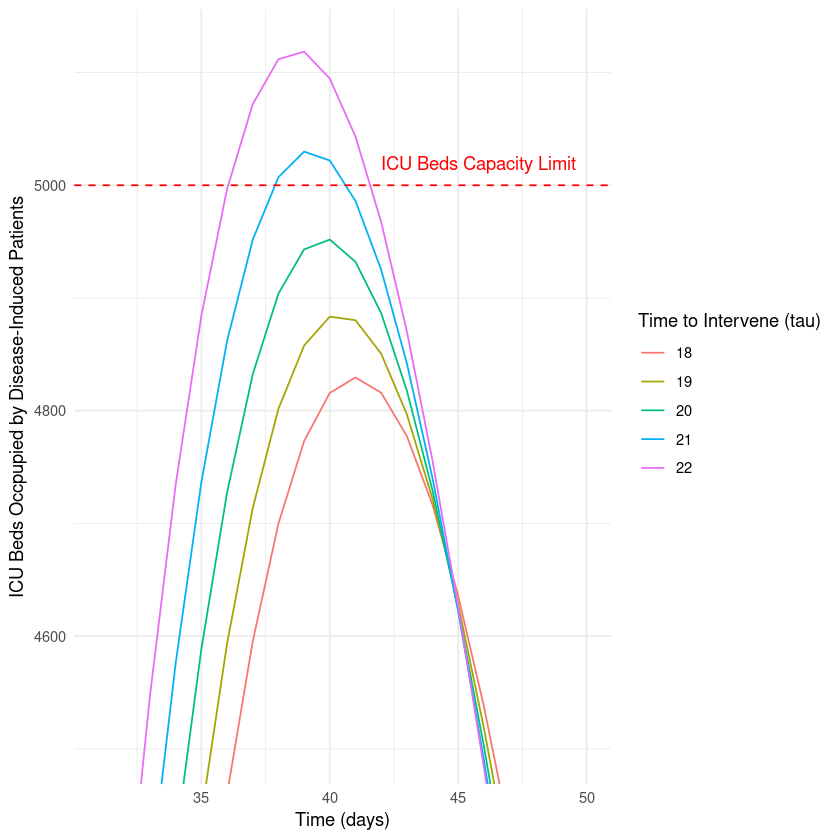

In [38]:
# Create zoomed-in plot
zoomed_plot <- ggplot(combined_df, aes(x = time, y = B_icu, color = as.factor(tau), group = tau)) +
  geom_line() +
  geom_hline(yintercept = icu_capacity, linetype = "dashed", color = "red") +
  coord_cartesian(xlim = c(31, 50), ylim = c(4500, 5125)) +
  labs(x = "Time (days)", y = "ICU Beds Occpupied by Disease-Induced Patients", color = "Time to Intervene (tau)") +
  annotate("text", x = 42, y = icu_capacity + 20, label = "ICU Beds Capacity Limit", color = "red", hjust = 0) +
  theme_minimal()

# Save the zoomed-in plot as a PDF
# ggsave("ICU_Cases_Tau_Zoom_narrow.pdf", plot = zoomed_plot, width = 10, height = 6)

# View the zoomed-in plot
print(zoomed_plot)

## Markov Chain Model To Plot S, E, I, R  Version 1

In [23]:
# # Markov Chain SEIR model with hospitalization compartments (B_N and B_ICU)
# simulate_markov_chain <- function(params, initial_conditions, times) {
#   S <- initial_conditions["S"]
#   E <- initial_conditions["E"]
#   I <- initial_conditions["I"]
#   R <- initial_conditions["R"]
#   B_n <- initial_conditions["B_n"]
#   B_icu <- initial_conditions["B_icu"]

#   N <- params["N"]
#   gamma <- params["gamma"]
#   alpha <- params["alpha"]
#   lambda1 <- params["lambda1"]
#   lambda2 <- params["lambda2"]
#   sigma <- params["sigma"]
#   delta <- params["delta"]
#   theta <- params["theta"]
#   q <- params["q"]
#   tau <- params["tau"]
#   beta_0 <- params["beta_0"]
#   beta_1 <- params["beta_1"]

#   results <- data.frame(time = times, 
#                         S = numeric(length(times)), 
#                         E = numeric(length(times)), 
#                         I = numeric(length(times)), 
#                         R = numeric(length(times)), 
#                         B_n = numeric(length(times)),
#                         B_icu = numeric(length(times)))

#   for (t in times) {
#     beta <- beta_tt(t, params)
    
#     # Calculate probabilities for the events
#     p_SE <- 1 - exp(-(beta * I) / N)
#     p_EI <- 1 - exp(-sigma)
#     p_IR <- 1 - exp(-gamma)
#     p_IBn <- 1 - exp(-alpha)
#     p_BnR <- 1 - exp(-theta)
#     p_BnBicu <- 1 - exp(-lambda1)
#     p_BicuBn <- 1 - exp(-lambda2)
    
#     # Simulate the transitions
#     new_exposed <- rbinom(1, S, p_SE)
#     new_infectious <- rbinom(1, E, p_EI)
#     new_recovered <- rbinom(1, I, p_IR)
#     new_Bn <- rbinom(1, I, p_IBn)
#     new_Bn_recovered <- rbinom(1, B_n, p_BnR)
#     new_Bicu <- rbinom(1, B_n, p_BnBicu)
#     new_Bn_from_Bicu <- rbinom(1, B_icu, p_BicuBn)
    
#     # Update the compartments
#     S <- S - new_exposed
#     E <- E + new_exposed - new_infectious
#     I <- I + new_infectious - new_recovered - new_Bn
#     R <- R + new_recovered + new_Bn_recovered
#     B_n <- B_n + new_Bn - new_Bn_recovered - new_Bicu + new_Bn_from_Bicu
#     B_icu <- B_icu + new_Bicu - new_Bn_from_Bicu

#     # Store the results
#     results[results$time == t, ] <- c(t, S, E, I, R, B_n, B_icu)
#   }

#   return(results)
# }

In [26]:
# Calculate beta(t) dynamically based on time
beta_tt <- function(t, params) {
  if (t < params["tau"]) {
    return(params["beta_0"])
  } else {
    return(params["beta_1"] + (params["beta_0"] - params["beta_1"]) * exp(-params["q"] * (t - params["tau"])))
  }
}


In [27]:
# Markov Chain SEIR model with hospitalization compartments (B_N and B_ICU)
simulate_markov_chain <- function(params, initial_conditions, times) {
  S <- initial_conditions["S"]
  E <- initial_conditions["E"]
  I <- initial_conditions["I"]
  R <- initial_conditions["R"]
  B_n <- initial_conditions["B_n"]
  B_icu <- initial_conditions["B_icu"]

  N <- params["N"]
  gamma <- params["gamma"]
  alpha <- params["alpha"]
  lambda1 <- params["lambda1"]
  lambda2 <- params["lambda2"]
  sigma <- params["sigma"]
  delta <- params["delta"]
  theta <- params["theta"]
  q <- params["q"]
  tau <- params["tau"]
  beta_0 <- params["beta_0"]
  beta_1 <- params["beta_1"]

  results <- data.frame(time = times, 
                        S = numeric(length(times)), 
                        E = numeric(length(times)), 
                        I = numeric(length(times)), 
                        R = numeric(length(times)), 
                        B_n = numeric(length(times)),
                        B_icu = numeric(length(times)))

  for (t in times) {
    beta <- beta_tt(t, params)
    
    # Calculate probabilities for the events
    p_SE <- 1 - exp(-(beta * I) / N)
    p_EI <- 1 - exp(-sigma)
    p_IR <- 1 - exp(-gamma)
    p_IBn <- 1 - exp(-alpha)
    p_BnR <- 1 - exp(-theta)
    p_BnBicu <- 1 - exp(-lambda1)
    p_BicuBn <- 1 - exp(-lambda2)

    # Ensure probabilities are within [0, 1]
    p_SE <- min(max(p_SE, 0), 1)
    p_EI <- min(max(p_EI, 0), 1)
    p_IR <- min(max(p_IR, 0), 1)
    p_IBn <- min(max(p_IBn, 0), 1)
    p_BnR <- min(max(p_BnR, 0), 1)
    p_BnBicu <- min(max(p_BnBicu, 0), 1)
    p_BicuBn <- min(max(p_BicuBn, 0), 1)

    # Debugging outputs
    if (any(is.na(c(p_SE, p_EI, p_IR, p_IBn, p_BnR, p_BnBicu, p_BicuBn)))) {
      cat("Warning: NA probabilities at time", t, "\n")
      print(data.frame(time = t, p_SE = p_SE, p_EI = p_EI, p_IR = p_IR, p_IBn = p_IBn, p_BnR = p_BnR, p_BnBicu = p_BnBicu, p_BicuBn = p_BicuBn))
    }

    # Simulate the transitions
    new_exposed <- rbinom(1, S, p_SE)
    new_infectious <- rbinom(1, E, p_EI)
    new_recovered <- rbinom(1, I, p_IR)
    new_Bn <- rbinom(1, I, p_IBn)
    new_Bn_recovered <- rbinom(1, B_n, p_BnR)
    new_Bicu <- rbinom(1, B_n, p_BnBicu)
    new_Bn_from_Bicu <- rbinom(1, B_icu, p_BicuBn)

    # Update the compartments
    S <- S - new_exposed
    E <- E + new_exposed - new_infectious
    I <- I + new_infectious - new_recovered - new_Bn
    R <- R + new_recovered + new_Bn_recovered
    B_n <- B_n + new_Bn - new_Bn_recovered - new_Bicu + new_Bn_from_Bicu
    B_icu <- B_icu + new_Bicu - new_Bn_from_Bicu

    # Ensure compartments are non-negative
    S <- max(S, 0)
    E <- max(E, 0)
    I <- max(I, 0)
    R <- max(R, 0)
    B_n <- max(B_n, 0)
    B_icu <- max(B_icu, 0)

    # Store the results
    results[results$time == t, ] <- c(t, S, E, I, R, B_n, B_icu)
  }

  return(results)
}

In [28]:
# Simulate the Markov Chain model
markov_results <- simulate_markov_chain(params, initial_conditions, times)


In [29]:
head(markov_results)

,time,S,E,I,R,B_n,B_icu
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,119821,167,18,6,38,10
2,2,119770,194,34,9,15,38
3,3,119667,268,43,16,51,15
4,4,119554,344,59,22,30,51
5,5,119394,448,79,28,81,30
6,6,119178,576,123,37,65,81


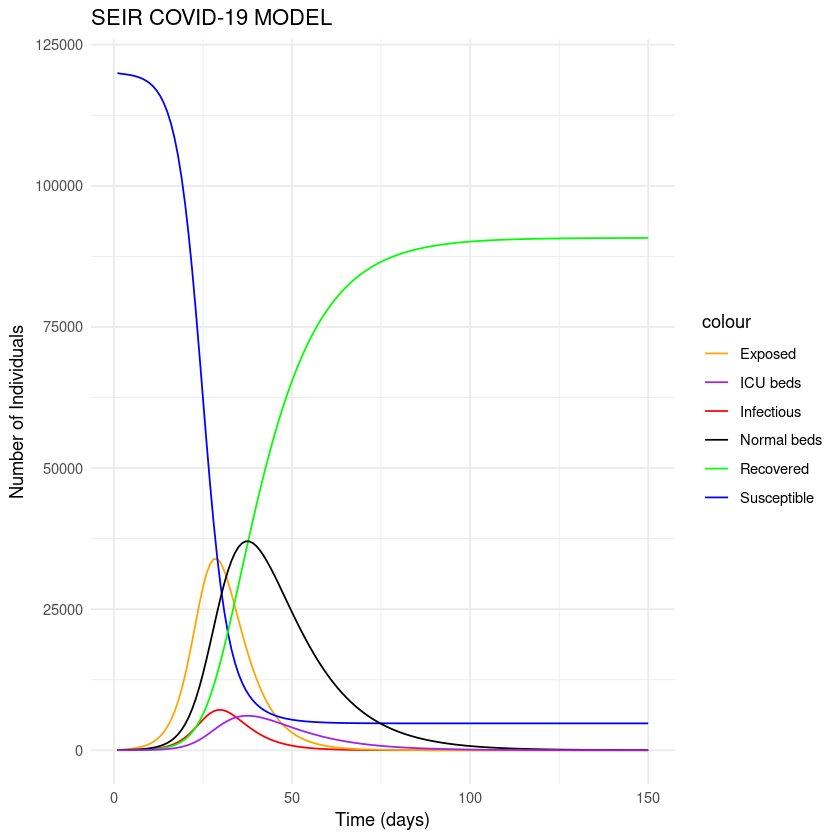

In [30]:
# Plot the simulation results
ggplot(seir_df, aes(x = time)) +
  geom_line(aes(y = I, color = "Infectious")) +
  geom_line(aes(y = E, color = "Exposed")) +
  geom_line(aes(y = S, color = "Susceptible")) +
  geom_line(aes(y = R, color = "Recovered")) +
  geom_line(aes(y = B_n, color = "Normal beds")) +
  geom_line(aes(y = B_icu, color = "ICU beds")) +
  labs(title = "SEIR COVID-19 MODEL",
       x = "Time (days)", y = "Number of Individuals") +
  scale_color_manual(values = c("Infectious" = "red", "Exposed" = "orange", "Susceptible" = "blue", "Recovered" ="green","Normal beds" = "black","ICU beds" = "purple")) +
  theme_minimal()

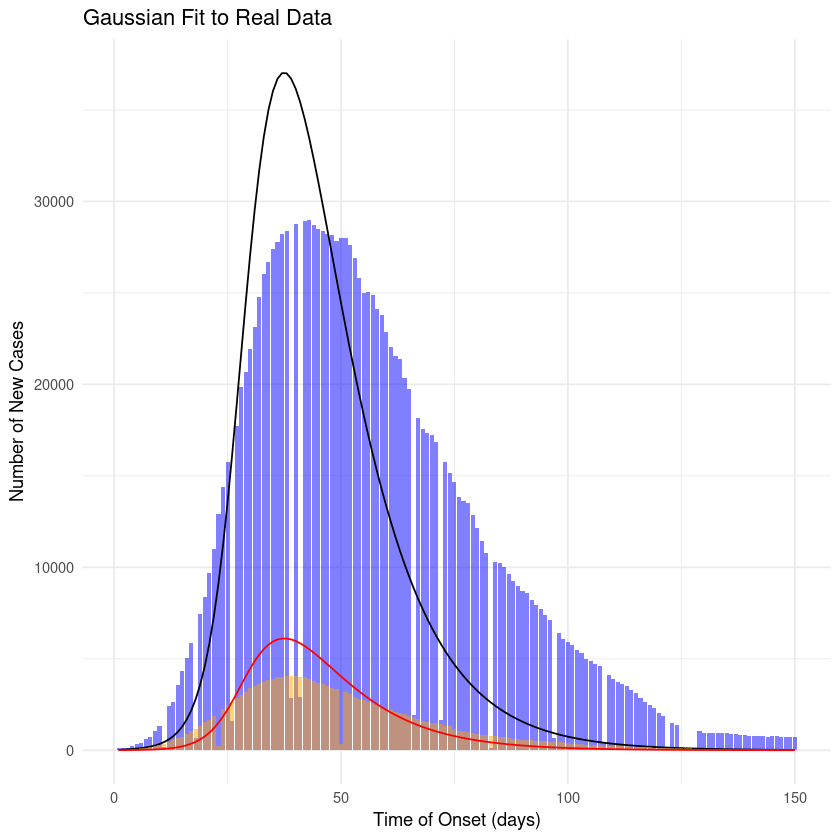

In [31]:
# Plot the real data and Gaussian fit
ggplot() +
  geom_bar(data = covid_bed, aes(x = times, y = non_icu), stat = "identity", fill = "blue", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_n), color = "black") +
  geom_bar(data = covid_bed, aes(x = times, y = icu), stat = "identity", fill = "orange", alpha = 0.5) +
  geom_line(data = seir_df, aes(x = times, y = B_icu), color = "red") +
  labs(title = "Gaussian Fit to Real Data",
       x = "Time of Onset (days)", y = "Number of New Cases") +
  theme_minimal()

## Markov Chain Model Version 2

## Initial Conditions

In [30]:
# Parameters and initial conditions
latent_period <- 5.6  # [days]
params <- c(
  beta_0 = 2.8,
  beta_1 = 2,
  gamma = 1/12,
  alpha = 0.75,
  lambda1 = 10,
  lambda2 = 60.5,
  theta = 1/15,
  delta = 1/8,
  tau = 500,
  q = 100,
  N = 120000,
  sigma = 1/latent_period
)

initial_conditions <- c(S = 120000-50, E = 0, I = 50, R = 0, B_n = 0, B_icu = 0, D = 0)
times <- seq(1, 150, by = 1)



In [31]:
# Calculate beta(t) dynamically based on time
beta_tt <- function(t, params) {
  if (t < params["tau"]) {
    return(params["beta_0"])
  } else {
    return(params["beta_1"] + (params["beta_0"] - params["beta_1"]) * exp(-params["q"] * (t - params["tau"])))
  }
}


In [32]:
# Stochastic SEIR model using Gillespie Algorithm
seir_gillespie <- function(params, initial_conditions, times) {
  t <- 0
  results <- data.frame(time = t, 
                        S = initial_conditions["S"], 
                        E = initial_conditions["E"], 
                        I = initial_conditions["I"], 
                        R = initial_conditions["R"], 
                        B_n = initial_conditions["B_n"],
                        B_icu = initial_conditions["B_icu"],
                        D = = initial_conditions["D"]
                       )
  
  while(t < max(times)) {
    S <- results$S[nrow(results)]
    E <- results$E[nrow(results)]
    I <- results$I[nrow(results)]
    R <- results$R[nrow(results)]
    B_n <- results$B_n[nrow(results)]
    B_icu <- results$B_icu[nrow(results)]
    D <- results$D[nrow(results)]
      
    N <- params["N"]
    gamma <- params["gamma"]
    alpha <- params["alpha"]
    lambda1 <- params["lambda1"]
    lambda2 <- params["lambda2"]
    sigma <- params["sigma"]
    delta <- params["delta"]
    theta <- params["theta"]
    beta <- beta_tt(t, params)
    
    # Rates of transitions
    rate_infection <- ifelse(S > 0, beta * S * I / N, 0)
    rate_exposed_to_infectious <- ifelse(E > 0, sigma * E, 0)
    rate_infectious_to_recovered <- ifelse(I > 0, gamma * I, 0)
    rate_infectious_to_Bn <- ifelse(I > 0, alpha * I, 0)
    rate_Bn_to_recovered <- ifelse(B_n > 0, theta * B_n, 0)
    rate_Bn_to_B_icu <- ifelse(B_n > 0, lambda1 * B_n, 0)
    rate_Bicu_to_Bn <- ifelse(B_icu > 0, lambda2 * B_icu, 0)
    rate_Bicu_to_D <- ifelse(B_icu > 0, delta * B_icu, 0)
    
    rates <- c(rate_infection, 
               rate_exposed_to_infectious, 
               rate_infectious_to_recovered,
               rate_infectious_to_Bn,
               rate_Bn_to_recovered,
               rate_Bn_to_B_icu,
               rate_Bicu_to_Bn,
               rate_Bicu_to_D
              )
    total_rate <- sum(rates)
    
    if(total_rate == 0) break
    
    # Time to next event
    dt <- rexp(1, total_rate)
    t <- t + dt
    
    # Determine which event occurs
    event <- sample(1:7, 1, prob = rates)
    
    if(event == 1 && S > 0) {
      S <- S - 1
      E <- E + 1
    } else if(event == 2 && E > 0) {
      E <- E - 1
      I <- I + 1
    } else if(event == 3 && I > 0) {
      I <- I - 1
      R <- R + 1
    } else if(event == 4 && I > 0) { 
      I <- I - 1
      B_n <- B_n + 1
    } else if(event == 5 && B_n > 0) { 
      B_n <- B_n - 1
      R <- R + 1
    } else if(event == 6 && B_n > 0) { 
      B_n <- B_n - 1
      B_icu <- B_icu + 1
    } else if(event == 7 && B_icu > 0) { 
      B_icu <- B_icu - 1
      B_n <- B_n + 1
    } else if(event == 8 && B_icu > 0) { 
      B_icu <- B_icu - 1
      D <- D + 1
    
    results <- rbind(results, data.frame(time = t, S = S, E = E, I = I, R = R, B_n = B_n, B_icu = B_icu, D = D))
  }
  
  return(results)
}


In [ ]:
# Number of simulations
num_simulations <- 10
all_simulations <- list()

for(i in 1:num_simulations) {
  sim_result <- seir_gillespie(params, initial_conditions, times)
  all_simulations[[i]] <- sim_result
}


In [ ]:
# Function to extract the final epidemic size from each simulation
final_epidemic_size <- function(simulation) {
  return(max(simulation$B_icu))
}

# Calculate final epidemic sizes for all simulations
final_sizes <- sapply(all_simulations, final_epidemic_size)

# Plot the distribution of final epidemic sizes
hist(final_sizes, breaks = 30, main = "Distribution of Final Epidemic Sizes", xlab = "Final Epidemic Size", ylab = "Frequency")

# Calculate summary statistics
summary(final_sizes)


In [ ]:
# Plot a few sample simulations
# sample_indices <- sample(1:num_simulations, 5)
sample_indices <- sample(1:num_simulations)


plot(NULL, xlim = c(0, max(times)), ylim = c(0, max(sapply(all_simulations, function(sim) max(sim$I)))), 
     xlab = "Time (days)", ylab = "Number of Infectious Individuals", main = "Sample Epidemic Curves")

for(i in sample_indices) {
  lines(all_simulations[[i]]$time, all_simulations[[i]]$I, col = i, type = "l")
}

legend("topright", legend = paste("Simulation", sample_indices), col = sample_indices, lty = 1)


## Markov Chain Model Version 3 for the Time of Intervention Delay

## Initial Conditions

In [4]:
# Parameters and initial conditions
latent_period=5.6 #[days]
params <- c(
  beta_0 = 2.8,
  beta_1 = 2,
  gamma = 1/12,
  alpha = 0.75  ,
  lambda1 =10,
  lambda2 =60.5  ,
  theta = 1/15,
  delta = 1/8,
  tau = 500,
  q = 100,
  N = 500 ,
  sigma=1/latent_period  )  
    
initial_conditions <- c(S =500-5, E = 10, I = 5, R = 10, B_n=0,B_icu=0)
times <- seq(1, 150, by = 1)

In [5]:
# Stochastic SEIR model using Gillespie Algorithm
seir_gillespie <- function(params, initial_conditions, times) {
  t <- 0
  results <- data.frame(time = t, 
                        S = initial_conditions["S"], 
                        E = initial_conditions["E"], 
                        I = initial_conditions["I"], 
                        R = initial_conditions["R"], 
                        B_n = initial_conditions["B_n"],
                        B_icu = initial_conditions["B_icu"],
                        D = = initial_conditions["D"]
                       )
  
  while(t < max(times)) {
    S <- results$S[nrow(results)]
    E <- results$E[nrow(results)]
    I <- results$I[nrow(results)]
    R <- results$R[nrow(results)]
    B_n <- results$B_n[nrow(results)]
    B_icu <- results$B_icu[nrow(results)]
    D <- results$D[nrow(results)]
      
    N <- params["N"]
    gamma <- params["gamma"]
    alpha <- params["alpha"]
    lambda1 <- params["lambda1"]
    lambda2 <- params["lambda2"]
    sigma <- params["sigma"]
    delta <- params["delta"]
    theta <- params["theta"]
    beta <- beta_tt(t, params)
    
    # Rates of transitions
    rate_infection <- ifelse(S > 0, beta * S * I / N, 0)
    rate_exposed_to_infectious <- ifelse(E > 0, sigma * E, 0)
    rate_infectious_to_recovered <- ifelse(I > 0, gamma * I, 0)
    rate_infectious_to_Bn <- ifelse(I > 0, alpha * I, 0)
    rate_Bn_to_recovered <- ifelse(B_n > 0, theta * B_n, 0)
    rate_Bn_to_B_icu <- ifelse(B_n > 0, lambda1 * B_n, 0)
    rate_Bicu_to_Bn <- ifelse(B_icu > 0, lambda2 * B_icu, 0)
    rate_Bicu_to_D <- ifelse(B_icu > 0, delta * B_icu, 0)
    
    rates <- c(rate_infection, 
               rate_exposed_to_infectious, 
               rate_infectious_to_recovered,
               rate_infectious_to_Bn,
               rate_Bn_to_recovered,
               rate_Bn_to_B_icu,
               rate_Bicu_to_Bn,
               rate_Bicu_to_D
              )
    total_rate <- sum(rates)
    
    if(total_rate == 0) break
    
    # Time to next event
    dt <- rexp(1, total_rate)
    t <- t + dt
    
    # Determine which event occurs
    event <- sample(1:7, 1, prob = rates)
    
    if(event == 1 && S > 0) {
      S <- S - 1
      E <- E + 1
    } else if(event == 2 && E > 0) {
      E <- E - 1
      I <- I + 1
    } else if(event == 3 && I > 0) {
      I <- I - 1
      R <- R + 1
    } else if(event == 4 && I > 0) { 
      I <- I - 1
      B_n <- B_n + 1
    } else if(event == 5 && B_n > 0) { 
      B_n <- B_n - 1
      R <- R + 1
    } else if(event == 6 && B_n > 0) { 
      B_n <- B_n - 1
      B_icu <- B_icu + 1
    } else if(event == 7 && B_icu > 0) { 
      B_icu <- B_icu - 1
      B_n <- B_n + 1
    } else if(event == 8 && B_icu > 0) { 
      B_icu <- B_icu - 1
      D <- D + 1
    
    results <- rbind(results, data.frame(time = t, S = S, E = E, I = I, R = R, B_n = B_n, B_icu = B_icu, D = D))
  }
  
  return(results)
}


In [6]:

# # Number of simulations for each tau
# num_simulations <- 2

# # Define range of intervention times (tau)
# tau_values <- seq(0, 100, by = 50)

# # Collect results
# final_sizes <- data.frame(tau = tau_values, mean_final_size = NA, sd_final_size = NA)

# for (tau in tau_values) {
#   params["tau"] <- tau
#   epidemic_sizes <- numeric(num_simulations)
  
#   for (i in 1:num_simulations) {
#     sim_result <- seir_gillespie(params, initial_conditions, times)
#     epidemic_sizes[i] <- max(sim_result$B_icu)
#   }
  
#   final_sizes[final_sizes$tau == tau, "mean_final_size"] <- mean(epidemic_sizes)
#   final_sizes[final_sizes$tau == tau, "sd_final_size"] <- sd(epidemic_sizes)
# }

num_simulations <- 2
tau_values <- seq(0, 100, by = 50)
final_sizes <- data.frame(tau = tau_values, mean_final_size = NA, sd_final_size = NA)

for (tau in tau_values) {
  params["tau"] <- tau
  epidemic_sizes <- numeric(num_simulations)
  
  for (i in 1:num_simulations) {
    cat("Running simulation", i, "for tau =", tau, "\n")
    sim_result <- seir_gillespie(params, initial_conditions, times)
    epidemic_sizes[i] <- max(sim_result$I)
  }
  
  final_sizes[final_sizes$tau == tau, "mean_final_size"] <- mean(epidemic_sizes)
  final_sizes[final_sizes$tau == tau, "sd_final_size"] <- sd(epidemic_sizes)
}

print(final_sizes)

Running simulation 1 for tau = 0 


ERROR: Error in beta_tt(t, params): could not find function "beta_tt"


Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


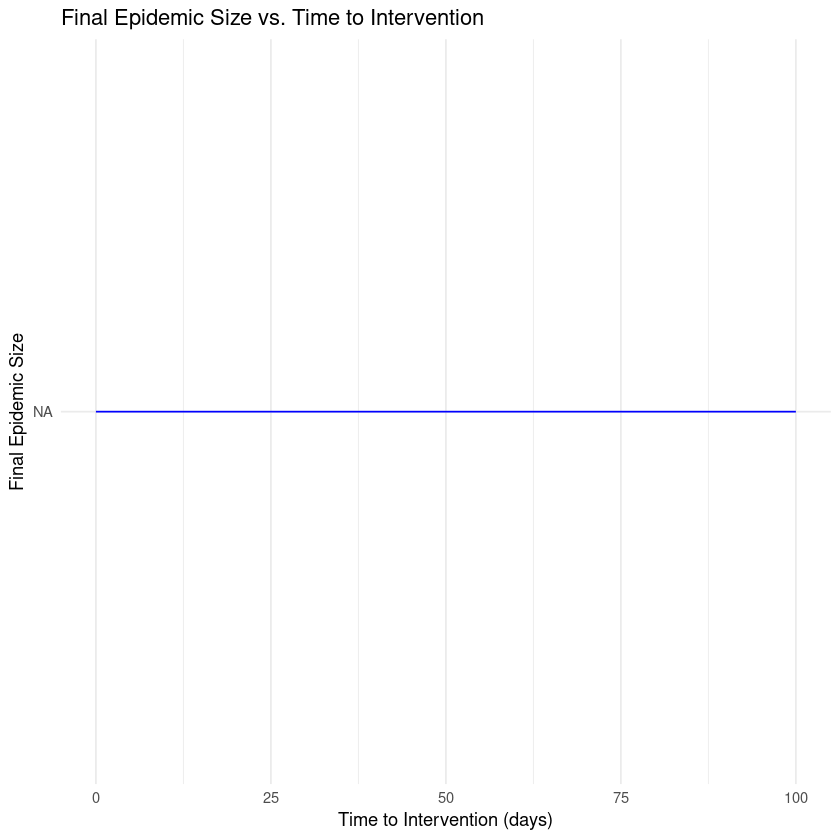

In [82]:
# Plot final epidemic size vs. time to intervention
ggplot(final_sizes, aes(x = tau, y = mean_final_size)) +
  geom_line(color = "blue") +
  geom_ribbon(aes(ymin = mean_final_size - sd_final_size, ymax = mean_final_size + sd_final_size), alpha = 0.2) +
  labs(title = "Final Epidemic Size vs. Time to Intervention",
       x = "Time to Intervention (days)",
       y = "Final Epidemic Size") +
  theme_minimal()


## Markov Chain Model Version 4 using the GillespieSSA Package

In [39]:
# Parameters and Initial Conditions 

latent_period <- 5.6 # [days]
params <- c(
  beta_0 = 2.8,
  beta_1 = 2,
  gamma = 1/12,
  alpha = 0.75,
  lambda1 = 10,
  lambda2 = 60.5,
  theta = 1/15,
  delta = 1/8,
  q = 100,
  N = 120000,
  sigma = 1/latent_period
)

initial_conditions <- c(S = 119920, E = 10, I = 50, R = 0, B_n = 10, B_icu = 10, D = 0)
times <- seq(1, 150, by = 1)
taus <- c(0, 10, 20, 30, 50)

In [40]:
# Define the propensities as character strings
propensity <- function(y, params, t) {
  beta <- beta_t(t, params["tau"], params["beta_0"], params["beta_1"], params["q"])
  N <- sum(y)
  return(c(
    (beta * y[1] * y[3]) / N,        # S -> E
    params["sigma"] * y[2],          # E -> I
    (params["gamma"] + params["alpha"]) * y[3],  # I -> R
    params["alpha"] * y[3],          # I -> B_n
    params["lambda2"] * y[6],        # B_icu -> B_n
    params["theta"] * y[5],          # B_n -> R
    params["lambda1"] * y[5],        # B_n -> B_icu
    params["delta"] * y[6]           # B_icu -> Deceased
  ))
}

# State change vectors (columns represent changes in S, E, I, R, B_n, B_icu, D)
transitions <- matrix(c(
  -1,  1,  0,  0,  0,  0,  0,          #  S -> E
   0, -1,  1,  0,  0,  0,  0,          #  E -> I
   0,  0, -1,  1,  0,  0,  0,         #  I -> R
   0,  0, -1,  0,  1,  0,  0,      #  I -> B_n
   0,  0,  0,  0,  1, -1,  0,         #  B_icu -> B_n
   0,  0,  0,  1, -1,  0,  0,        #  B_n -> R
   0,  0,  0,  0, -1,  1,  0,        #  B_n -> B_icu
   0,  0,  0,  0,  0, -1,  1         #  B_icu -> D
), byrow = TRUE, ncol = 7)


In [42]:
gillespie_results <- list()
for (tau in taus) {
  params["tau"] <- tau
  res <- ssa(
    x0 = initial_conditions,
    a = propensity,
    nu = transitions,
    parms = params,
    tf = max(times),
    method = "OTL",            #  optimized tau-leaping method
    tau = 0.1
  )
  gillespie_results[[as.character(tau)]] <- res
}

ERROR: Error in ssa(x0 = initial_conditions, a = propensity, nu = transitions, : 'a' is not of character type
